# Predicción de precios de inmuebles utilizando *machine learning*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1b9v6UljfpjzBYlOQrjvdEFNdiEH3oEiK)
***

La regresión es una de las técnicas más utilizadas en estadística y machine learning. Sin embargo, cuando se aplica a observaciones distribuidas espacialmente, se puede perder mucho poder predictivo al ignorar la presencia de autocorrelación espacial.

Con el objetivo de estudiar estas correlaciones espaciales, utilizaremos una base de datos sobre precios de inmuebles en California. La fuente de los datos proviene de Pace y Barry (1997). El objetivo es generar predicciones del precio de los inmuebles en California, dado su posición geográfica.

Descripción de variables:

| Variable | Descripción |
|:-|:-|
|Longitud         |medida (en grados º) de qué tan al oeste está una casa; un valor más alto implica un hogar más oeste |
|Latitud          |medida (en grados º) de qué tan al norte está un hogar; un valor más alto implica un hogar más al norte|
|AntiguedadMedia  |promedio de la antiguedad de los hogares en ese bloque (un nº menor implica inmuebles construidos más recientemente)|
|Habitaciones     |nº total de habitaciones en ese bloque (por ejemplo: una cuadra)|
|Banos            |nº total de baños en ese bloque (por ejemplo: una cuadra)|
|Poblacion        |nº total de personas que viven en ese bloque (por ejemplo: una cuadra)|
|Hogares          |nº total de hogares para un bloque (por ejemplo: una cuadra)|
|IngresoMedio     |promedio del ingresos de los hogares dentro del bloque (medido en decenas de miles de dólares americanos USD) [USD 10.000]|
|ValorMedioHogar  |promedio del precios de los inmuebles para los hogares dentro de un bloque (medido en dólares americanos USD) [USD]|


A continuación, prepararemos nuestro ambiente de trabajo: importaremos las librerías necesarias para nuestra análisis y cargaremos los datos (notar que los datos están disponibles en github, por lo que pueden leer los datos directamente a través de url que aparece más abajo).
***

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# cargamos los datos y vemos sus dimensiones
df = pd.read_csv('https://raw.githubusercontent.com/ssantanar/datasets/master/housing_california/california_housing.csv')
print(f"Observaciones : {df.shape[0]:,}")
print(f"Columnas      : {df.shape[1]}")
df.head()

Observaciones : 20,639
Columnas      : 9


Longitud  Latitud  AntiguedadMedia  Habitaciones   Banos  Poblacion  \
0   -122.22    37.86             21.0        7099.0  1106.0     2401.0   
1   -122.24    37.85             52.0        1467.0   190.0      496.0   
2   -122.25    37.85             52.0        1274.0   235.0      558.0   
3   -122.25    37.85             52.0        1627.0   280.0      565.0   
4   -122.25    37.85             52.0         919.0   213.0      413.0   

   Hogares  IngresoMedio  ValorMedioHogar  
0   1138.0        8.3014         358500.0  
1    177.0        7.2574         352100.0  
2    219.0        5.6431         341300.0  
3    259.0        3.8462         342200.0  
4    193.0        4.0368         269700.0

Cómo de costumbre, es necesario ver si existen datos atípicos, outliers o errores. Para esto, tal como lo hemos hecho en los cursos anteriores, utilizaremos el método `describe()`.

In [4]:
# estadísticos descriptivos para nuestros datos
df.describe().round(2)

Longitud   Latitud  AntiguedadMedia  Habitaciones     Banos  Poblacion  \
count  20639.00  20639.00         20639.00      20639.00  20639.00   20639.00   
mean    -119.57     35.63            28.64       2635.85    537.92    1425.53   
std        2.00      2.14            12.59       2181.63    421.25    1132.46   
min     -124.35     32.54             1.00          2.00      1.00       3.00   
25%     -121.80     33.93            18.00       1448.00    295.50     787.00   
50%     -118.49     34.26            29.00       2127.00    435.00    1166.00   
75%     -118.01     37.71            37.00       3148.00    647.00    1725.00   
max     -114.31     41.95            52.00      39320.00   6445.00   35682.00   

        Hogares  IngresoMedio  ValorMedioHogar  
count  20639.00      20639.00         20639.00  
mean     499.56          3.87        206843.91  
std      382.33          1.90        115385.73  
min        1.00          0.50         14999.00  
25%      280.00          2.56        119600.00  
50%      409.00          3.53        179700.00  
75%      605.00          4.74        264700.00  
max     6082.00         15.00        500001.00

In [5]:
# valores perdidos en las comunas de nuestro dataset: notar que no tenemos valores perdidos
df.isna().sum()

Longitud           0
Latitud            0
AntiguedadMedia    0
Habitaciones       0
Banos              0
Poblacion          0
Hogares            0
IngresoMedio       0
ValorMedioHogar    0
dtype: int64

A continuación veremos la distribución de las diferentes variables númericas de este conjunto de datos. Se destaca en rojo el promedio de la serie, y en verde la mediana.

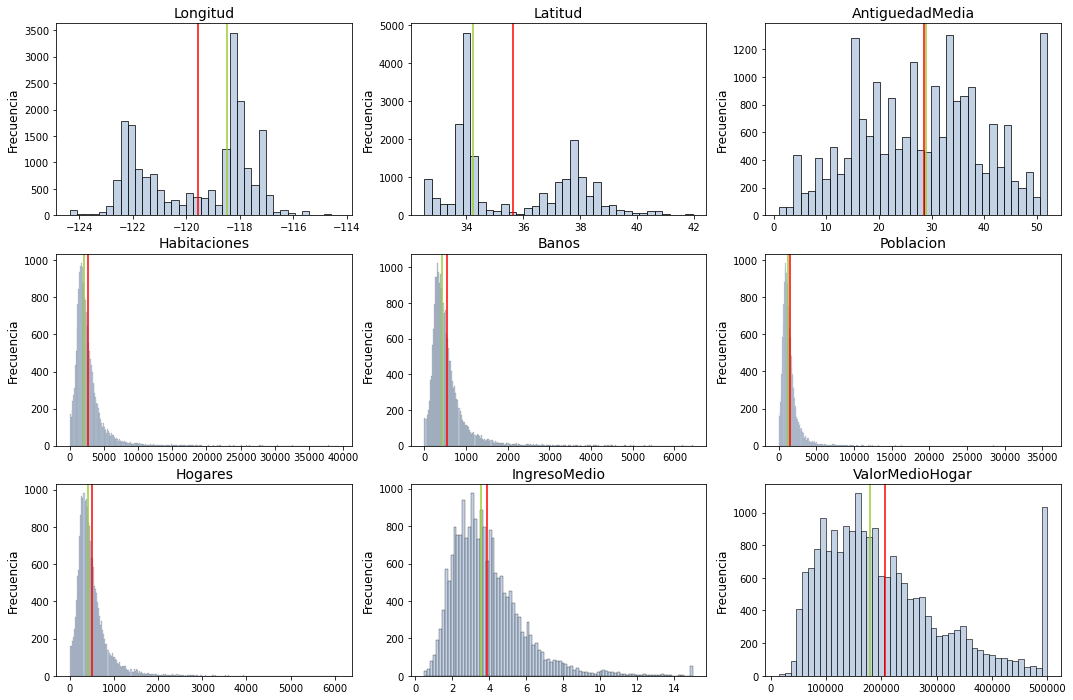

In [6]:
rows, cols = df.shape
nrows, ncols = (3,3)
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12))

# iteramos sobre las columnas del grafico y graficamos
for index, (colname, serie) in enumerate(df.iteritems()):
    ax = sns.histplot(serie, color='lightsteelblue', ax=axes[index//nrows,index%ncols])
    ax.set_title(f'{colname}',fontsize=14)
    ax.set_ylabel('Frecuencia',fontsize=12)
    ax.set_xlabel('')
    ax.axvline(x=np.mean(df[colname]), color='r')
    ax.axvline(x=np.nanmedian(df[colname]), color='yellowgreen')

<AxesSubplot:>

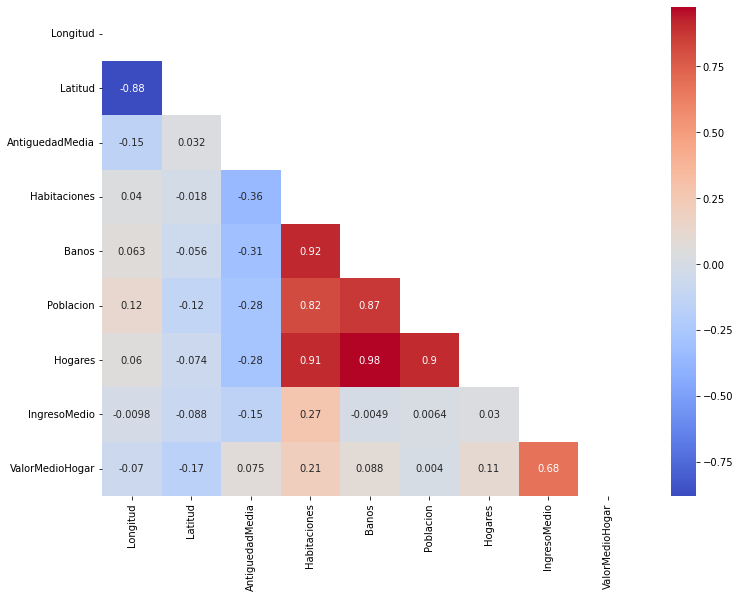

In [7]:
# matriz de correlación
plt.figure(figsize=(12,9))
# computamos matriz de correlación
corr_matrix = df.corr(method='spearman')
# esto nos permite graficar sólo la parte superior o inferior de la matriz
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# plot
sns.heatmap(corr_matrix,mask=mask,annot=True, cmap='coolwarm')

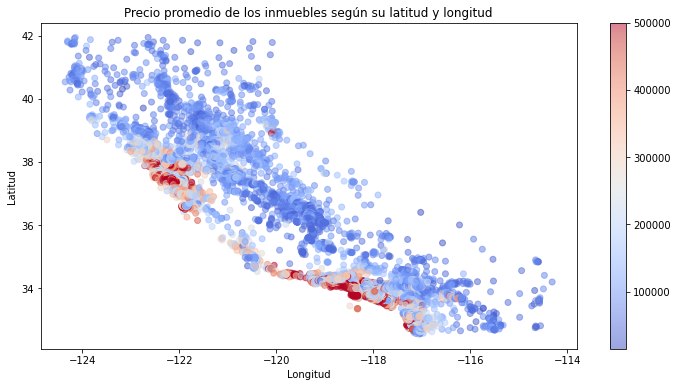

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
plt.scatter(df['Longitud'],
            df['Latitud'],
            c = df['ValorMedioHogar'],
            cmap='coolwarm',
            alpha=.5)
plt.colorbar()
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Precio promedio de los inmuebles según su latitud y longitud');

**Observaciones**:

- Muchos histogramas muestran una distribución con una cola pesada, esto es: se extienden mucho más hacia un lado de la distribución que hacia el otro (en estos casos, típicamente se extienden mucho hacia la derecha). Esto puede dificultar un poco que algunos algoritmos de *machine learning* detecten patrones o los puedan cuantificar adecuadamente.

- Hay atributos con que presentan una correlación fuerte (ver Habitaciones con Baños, Habitaciones con Población, Habitaciones con Hogares, Baños con Población, Baños con Hogares y Hogares con Población).

- Existen zonas donde efectivamente los precios son más altos en función de su localización, por lo que aparentemente este es un atributo importante a considerar para predecir el precio de los inmuebles.

***
# Desafío

Tal como se adelantó al comienzo, el objetivo de este desafío es predecir el valor promedio de los inmuebles ubicados en un determinado bloque, en función de las características de ese bloque (Habitaciones, Baños, Ingreso promedio, etc.). Para esto se le solicita que entrene un regresor, en particular un árbol de regresión utilizando la implementación de la librería scikit-learn, librería que ha sido presentada en el curso anterior. Además, como parte de la evaluación de este módulo se le solicita que responda las siguientes preguntas:

1. ¿Qué métricas de evaluaciones son apropiadas para este tipo de problema?
2. ¿Considera que es necesario transformar alguna variable? ¿Cuáles?
4. ¿Se debe mantener todas las variables dentro del dataset, o se deberían descartar algunas?
5. ¿Qué variables son las que mayor impacto tienen en la predicción del precio de los hogares (responda esta pregunta basado en los resultados del entrenamiento de su modelo)?

Finalmente, se le pide predecir el precio promedio de los inmuebles ubicados en un bloque con las siguientes características:

|Longitud| Latitud| AntiguedadMedia| Habitaciones| Banos| Poblacion |Hogares |IngresoMedio|
| - |- |- |- |- |- |- |- |
| -122.25 | 39.43 | 25.0 | 920.0 |281.0 | 558.0 | 177.0 | 1.8872 |

# Recomendaciones

1. La implementación de árboles de regresión de scikit-learn la puede encontrar en el siguiente enlace: [sklearn.tree.DecisionTreeRegressor](https://scikitlearn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
2. Si tiene dudas sobre qué son y cómo se diferencian las métricas de evaluación para los distintos problemas de machine learning, puede investigar sobre el tema en el libro "Guía para desarrolladores" de Amazon Machine Learning (2022), en el apartado "Evaluación de la precisión del modelo" (página 15)
3. Recuerde que en los modelos de árboles, un atributo tiene mayor poder predictivo si se encuentra en los nodos superiores, por que lo puede descubrir qué atributos tienen el mayor poder predictivo mediante el método `Tree` disponible en scikit-learn: [Tree-scikit-learn](https://scikit-learn.org/stable/modules/tree.html)
4. Para realizar una predicción, una vez entrenado su modelo (supongamos que guarda su modelo entrenado en la variable *reg_tree*), sólo necesita entregarle el dataframe con los valores señalados arriba y utilizar el método `.predict()`. Así, si su dataframe está en la variable *df_prediction*, y su modelo en *reg_tree*, sólo basta ejecutar el siguiente comando: `reg_tree.predict(df_prediction)`.

**Referencias**

- Pace, R. K., y Barry, R. (1997). Sparse spatial autoregressions. Statistics & Probability Letters, 33(3), 291-297.
- Amazon Machine Learning. (2022). Guía para desarrolladores. Disponible en: https://docs.aws.amazon.com/es_es/machine-learning/latest/dg/machinelearning-dg.pdf#regression. Consultado el 2 de mayo del 2022.